In [1]:
# Import dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data():
    datafile = "station.csv"
    f = open(datafile)
    data = f.read()
    f.close()
    lines = data.split("\n")
    header = lines[0].split(",")
    lines = lines[1:]
    temperature = []
    for line in lines:
        if line:
            linedata = line.split(",")
            linedata = linedata[1:13]
            for item in linedata:
                temperature.append(float(item))
    series= np.asarray(temperature)
    time= np.arange(len(temperature), dtype= "float32")
    return time, series

In [3]:
# Normalize the data
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std

In [4]:
split_time = 700
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
 series = tf.expand_dims(series, axis=-1)
 dataset = tf.data.Dataset.from_tensor_slices(series)
 dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
 dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
 dataset = dataset.shuffle(shuffle_buffer).map(
 lambda window: (window[:-1], window[-1]))
 dataset = dataset.batch(batch_size).prefetch(1)
 return dataset

In [6]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size,
 batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,
 batch_size, shuffle_buffer_size)


In [7]:
model = tf.keras.models.Sequential([
 tf.keras.layers.SimpleRNN(100, return_sequences=True,
 input_shape=[None, 1]),
 tf.keras.layers.SimpleRNN(100),
 tf.keras.layers.Dense(1)
])

In [8]:
optimizer = tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
 optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1,
 validation_data=valid_dataset)

Epoch 1/500


c:\Users\aiakintoye\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


57/57 [==============================] - 5s 53ms/step - loss: 0.5099 - mae: 0.9310 - val_loss: 0.5806 - val_mae: 1.0223
Epoch 2/500
57/57 [==============================] - 1s 17ms/step - loss: 0.4168 - mae: 0.8246 - val_loss: 0.4842 - val_mae: 0.9184
Epoch 3/500
57/57 [==============================] - 1s 17ms/step - loss: 0.3314 - mae: 0.7207 - val_loss: 0.3991 - val_mae: 0.8203
Epoch 4/500
57/57 [==============================] - 1s 16ms/step - loss: 0.2596 - mae: 0.6261 - val_loss: 0.3264 - val_mae: 0.7298
Epoch 5/500
57/57 [==============================] - 1s 19ms/step - loss: 0.2025 - mae: 0.5433 - val_loss: 0.2675 - val_mae: 0.6502
Epoch 6/500
57/57 [==============================] - 1s 17ms/step - loss: 0.1594 - mae: 0.4750 - val_loss: 0.2214 - val_mae: 0.5811
Epoch 7/500
57/57 [==============================] - 1s 17ms/step - loss: 0.1275 - mae: 0.4190 - val_loss: 0.1858 - val_mae: 0.5230
Epoch 8/500
57/57 [==============================] - 1s 17ms/step - loss: 0.1043 - mae: 

In [9]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("value")
    plt.grid(True)

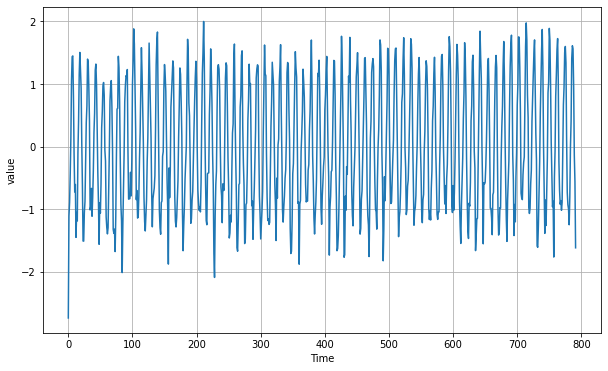

In [10]:
plt.figure(figsize=(10, 6))
# plt.axis([790,840,-0.5,0])
plot_series(time, series)

In [11]:
print(series[790:840])

[-0.56091745 -1.61765954]


In [12]:
start_point = 750

In [13]:
print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(series[start_point:start_point+window_size][np.newaxis]))

[ 1.88800964  1.694112    0.99608053  0.0653719  -0.48723635 -0.96034657
 -0.87309263 -1.76502174 -0.49499225 -0.06841746  0.80412188  1.14344273
  1.55062776  1.72513563  1.04649392 -0.24292533 -0.69858477 -0.92156704
 -0.86339775 -1.01851586 -0.8924824  -0.07811235  0.66839353  0.9495451 ]
1.5021533494042167
1/1 [==============================] - 0s 378ms/step
[[1.559529]]


In [14]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))


1/1 [==============================] - 0s 29ms/step


In [15]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

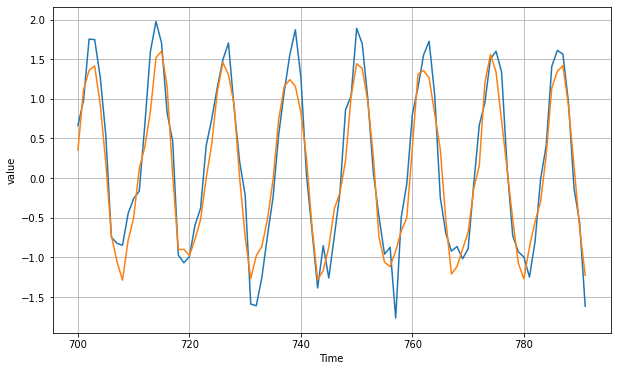

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
